# Coparing the efficiency of Bayesian network to predict soccer games compared to 538 match prediction algorithm

## Abstract

... tba

## Data and preprocessing

Dataset source : https://github.com/fivethirtyeight/data/tree/master/soccer-spi \
The dataset contains a list of every match from the most relevant leagues in the world from 2019 onwards. Fields include:

Header | Definition
---|---------
`season` | The season during which the match was played
`date` | The date of the match (YYYY-MM-DD)
`league_id` | A unique identifier for the league this match was played in
`league` | The name of the league this match was played in
`team1` | The home team's name
`team2` | The away team's name
`spi1` | The home team's overall SPI rating before the match
`spi2` | The away team's overall SPI rating before the match
`prob1` | The probability of the home team winning the match
`prob2` | The probability of the away team winning the match
`probtie` | The probability of match ending in a draw (if applicable)
`proj_score1` | The number of goals we expected the home team to score
`proj_score2` | The number of goals we expected the away team to score
`importance1` | The importance of the match for the home team (0-100)
`importance2` | The importance of the match for the away team (0-100)
`score1` | The number of goals scored by the home team
`score2` | The number of goals scored by the away team
`xg1` | The number of expected goals created by the home team
`xg2` | The number of expected goals created by the away team
`nsxg1` | The number of non-shot expected goals created by the home team
`nsxg2` | The number of non-shot expected goals created by the away team
`adj_score1` | The number of goals scored by the home team, adjusted for game state
`adj_score2` | The number of goals scored by the home team, adjusted for game state

Before proceding with the costruction of the network several preprocessing steps are required in order to gather useful information to feed to the network:
- Our analysis is going to focus on Europe's top 5 leagues, starting from the 2020-2021 season to the 2022-2023 season
- For the aim of project we 

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator, ParameterEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion
from pgmpy.inference.CausalInference import CausalInference
from pgmpy.factors.discrete import TabularCPD

/Users/andreacristiano/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#entire dataset: all matches from all the leagues
df = pd.read_csv('./spi_matches.csv')
#subset containing matches from the 2021 and 2022 serieA seasons
seasons=3
df_league = df.loc[(df['league_id'] == 1854) & (df['season'].isin([2020, 2021, 2022]))].copy()
df_league.shape

(1140, 23)

In [4]:
df_league.head()

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
34344,2020,2020-09-19,1854,Italy Serie A,Fiorentina,Torino,69.23,59.11,0.5212,0.2215,...,29.4,26.3,1.0,0.0,2.21,0.70,1.77,0.53,1.05,0.00
34368,2020,2020-09-19,1854,Italy Serie A,Verona,AS Roma,59.51,74.51,0.2425,0.5092,...,26.4,49.6,0.0,0.0,0.90,2.08,0.83,2.22,0.00,0.00
34405,2020,2020-09-20,1854,Italy Serie A,Parma,Napoli,56.69,79.05,0.1836,0.5929,...,31.9,59.1,0.0,2.0,0.25,1.37,0.85,1.25,0.00,1.93
34430,2020,2020-09-20,1854,Italy Serie A,Genoa,Crotone,55.90,53.39,0.4444,0.2801,...,38.3,38.9,4.0,1.0,2.24,1.53,1.42,0.78,4.09,1.05
34455,2020,2020-09-20,1854,Italy Serie A,Sassuolo,Cagliari,65.10,57.04,0.5043,0.2432,...,23.3,30.6,1.0,1.0,2.17,0.72,2.42,1.02,1.05,1.05


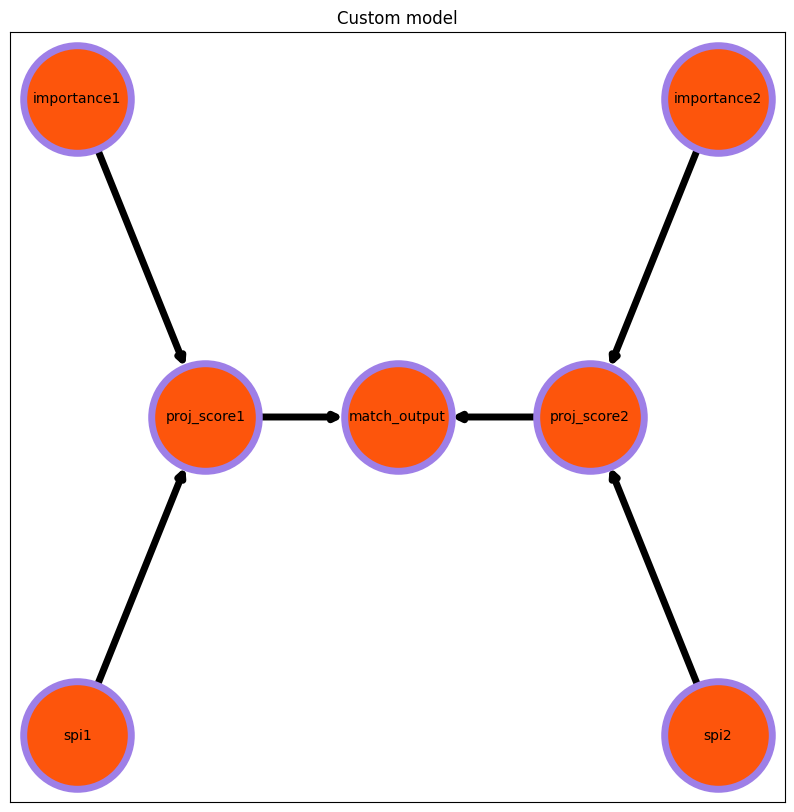

In [18]:
color_1='#fd550c'
color_2='#9e7fe7'

# Define the Bayesian Network structure
model = BayesianNetwork([('spi1', 'proj_score1'), ('importance1', 'proj_score1'),
         ('spi2', 'proj_score2'), ('importance2', 'proj_score2'),
         ('proj_score1', 'match_output'), ('proj_score2', 'match_output')])

pos = {'spi1': [-5, -1], 'importance1': [-5, 1],'importance2': [5, 1], 'spi2': [5, -1], 'proj_score1': [-3, 0],'proj_score2': [3, 0], 'match_output': [0, 0.0], }

options = {
    "font_size": 10,
    "node_size": 6000,
    "edgecolors": color_2,
    "node_color": color_1,
    "font_color": "black",
    "linewidths": 5,
    "width": 5,
}
G=BayesianNetwork(model)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title('Custom model')
nx.draw_networkx(model, pos, **options)
plt.savefig('images/bayesian_model.png')

In [6]:
class PredictiveModel:
    def __init__(self, df, discrete_importance, discrete_spi, discrete_score, matchday_split):
        # parameters for discretization of the dataset
        self.importance = discrete_importance
        self.spi = discrete_spi
        self.score = discrete_score
        # we assume that the df inside here already has matchday and match_output columns
        self.data = df
        self.league=self.data['league'].iloc[0]
        self.data = self.discretize()
        self.x_train, self.y_train, self.x_test, self.y_test = self.split_dataset_by_matchday(matchday_split)
        self.train()

    def train(self):
        
        self.model = BayesianNetwork([('spi1', 'proj_score1'), ('importance1', 'proj_score1'),
         ('spi2', 'proj_score2'), ('importance2', 'proj_score2'),
         ('proj_score1', 'match_output'), ('proj_score2', 'match_output')])
        features = ['spi1', 'proj_score1',  'importance1','spi2', 'proj_score2',  'importance2', 'match_output']
        data_train = self.x_train[features].copy()

        self.model.fit(data_train, estimator=MaximumLikelihoodEstimator)
        self.inference = VariableElimination(self.model)
    
    def get_cpds(self):
        return self.model.get_cpds()

    def get_df(self):
        return self.data
    
    def compare_probabilities(self, prediction, prob1, prob2, probtie):
        #auxiliary function to print the prediction of the models for each match
        
        print(f'Draw \n My model: {round(prediction[0],2)} - 538: {probtie}')
        print(f'Home win \n My model: {round(prediction[1],2)} - 538: {prob1}')
        print(f'Away win \n My model: {round(prediction[2],2)} - 538: {prob2}')

    def discretize(self):
        '''
        Function responsible for the preprocessing of the whole dataset.
        The importance, spi and proj_score columns the values are discretized according to
        the discretization values defined in the constructor

        This function is also adds the matchday and matchoutput columns. 
        The matchday column simpy indicates the matchday a certain match is played in.
        The match_output column is 0 if the match resulted in a draw, 1 if the match resulted in a home win,
        2 if the match resulted in an away win
        '''
        
        self.data.loc[:,'importance1'] = pd.to_numeric(self.data['importance1'], errors='coerce')
        self.data.loc[:,'importance2'] = pd.to_numeric(self.data['importance2'], errors='coerce')

        self.data.loc[:,'spi1'] = pd.to_numeric(self.data['spi1'], errors='coerce')
        self.data.loc[:,'spi2'] = pd.to_numeric(self.data['spi2'], errors='coerce')

        self.data.loc[:,'proj_score1'] = pd.to_numeric(self.data['proj_score1'], errors='coerce')
        self.data.loc[:,'proj_score2'] = pd.to_numeric(self.data['proj_score2'], errors='coerce')
        
        # Discretize all the columns needed
        self.data.loc[:,'importance1'] = pd.cut(self.data['importance1'], bins=self.importance, labels=False) + 1
        self.data.loc[:,'importance2'] = pd.cut(self.data['importance2'], bins=self.importance, labels=False) + 1

        self.data.loc[:,'spi1'] = pd.cut(self.data['spi1'], bins=self.spi, labels=False) + 1
        self.data.loc[:,'spi2'] = pd.cut(self.data['spi2'], bins=self.spi, labels=False) + 1

        self.data.loc[:,'proj_score1'] = pd.cut(self.data['proj_score1'], bins=self.score, labels=False) + 1
        self.data.loc[:,'proj_score2'] = pd.cut(self.data['proj_score2'], bins=self.score, labels=False) + 1

        self.data.loc[:,'match_output'] = np.where(self.data.loc[:,'score1'] == self.data.loc[:,'score2'], 0, 
                                    np.where(self.data.loc[:,'score1'] > self.data.loc[:,'score2'], 1, 2))
        
        teams = pd.concat([self.data['team1'], self.data['team2']]).unique()

        # Function to update matchday counts for each team
        def update_matchday(row, matchday_counts):
            team1 = row['team1']
            team2 = row['team2']
            matchday_counts[team1] += 1
            matchday_counts[team2] += 1
            return max(matchday_counts[team1], matchday_counts[team2])
        
        matchday_counts = {team: 0 for team in teams}

        self.data.loc[:, 'matchday'] = self.data.apply(update_matchday, axis=1, args=(matchday_counts,))
        self.data.dropna(inplace=True)

        return self.data

    def split_dataset_by_matchday(self, matchday):
        '''
        splits the dataset in training and test according to a specific matchday
        '''
        x_train = self.data[self.data['matchday'] < matchday]
        y_train = x_train['match_output']
        
        x_test = self.data[self.data['matchday'] >= matchday]
        y_test = x_test['match_output']
        
        return x_train,y_train, x_test, y_test

    def provide_evidence(self,match_row):
        '''
        auxiliary function to retrieve useful data for the inference process. it creates 
        the dictionary given as the evidence parameter in the inference function for pgmpy
        '''
        spi1 = match_row['spi1']
        spi2 = match_row['spi2']
        importance1 = match_row['importance1']
        importance2 = match_row['importance2']

        return {'spi1': spi1, 'spi2': spi2, 'importance1': importance1, 'importance2': importance2}

    def retrieve_matchday(self, matchday):
        """
        Function to calculate the accuracy of the predictions for each matchday.
        for each matchday it loops trough every match too see how many time the most likely
        result given by the predictor matches the actual result
        """
        df_current = self.data[self.data['matchday'] == matchday]
        #print("Matchday: ",matchday)
        correct_guess=0
        correct_5=0
        # Iterate over rows of the DataFrame
        for index, match in df_current.iterrows():

            max_prob=0
            max_538=-20
            outcome_5=80
            outcome=80
            
            evidence = self.provide_evidence(match)
            
            prediction = self.inference.query(variables=['match_output'], evidence=evidence).values
            #print(f"\n Home Team: {match['team1']} {match['score1']} - Away Team: {match['team2']} {match['score2']}")
            #self.compare_probabilities(prediction, match['prob1'], match['prob2'], match['probtie'])
            
            #calcola hitrate
            if (match['probtie']> max_538):
                max_538=match['probtie']
                outcome_5=0
            if (match['prob1']>=max_538):
                max_538=match['prob1']
                outcome_5=1
            if (match['prob2']>=max_538):
                max_538=match['prob2']
                outcome_5=2
            
            if (prediction[0]>=max_prob):
                max_prob=prediction[0]
                outcome=0
            if (prediction[1]>=max_prob):
                max_prob=prediction[1]
                outcome=1
            if (prediction[2]>=max_prob):
                max_prob=prediction[2]
                outcome=2
            
            # print(f'predicted outcome: {outcome}')
            # print(f'actual outcome: { match["match_output"] }')
            # print(f'is it right? {outcome == match["match_output"]}')

            if outcome_5 == match['match_output']:
                correct_5+=1
            if outcome == match['match_output']:
                correct_guess+=1
        
        # print(f'Correct predictions:{correct_guess}')

        return correct_guess, correct_5

    def predict(self):
        # Initialize lists to store results
        results = []

        # Train set prediction
        start = 1
        end = 20
        correct_my_train=0
        correct_538_train=0
        for i in range(start, end):
            my, other= self.retrieve_matchday(i)
            correct_my_train+=my
            correct_538_train+=other
        
        # results.append(['train', self.importance, self.spi, self.score, (end - start) * 10, correct_my_train,
        #                     correct_538_train, correct_my_train / ((end - start) * 10),
        #                     correct_538_train / ((end - start) * 10)])

        # Test set prediction
        start = 20
        end = 38
        correct_my_test=0
        correct_538_test=0
        for i in range(start, end):
            my, other= self.retrieve_matchday(i)
            correct_my_test+=my
            correct_538_test+=other
        
        results.append([self.league, self.importance, self.spi, self.score, (end - start) * 10, correct_my_test,
                            correct_538_test, correct_my_test / ((end - start) * 10),
                            correct_538_test / ((end - start) * 10)])

        # Create DataFrame from results
        columns = ['League', 'importance', 'spi', 'score', 'total_matches', 'my_correct', '538_correct',
                   'my_hitrate', '538_hitrate']
        df_results = pd.DataFrame(results, columns=columns)
        return df_results



### Parameters tuning

Let's test different discretization parameters to see which is the combination achieves the best results in testing and to see how much difference the parameter tuning actually makes on the model.

For each instance of the model we use the variable matchday_split to split the dataset into test and train set. We do the split based on the matchday to ensure that every team has played an equal amount of matches and to make it easier to retrieve specific matchdays.

In [7]:
matchday_split=seasons*38 - 18
results_list = []

for i in range(2, 7):
    for j in range(2,7):
        for k in range(2, 7):
            #reset a fresh copy of the dataset, in order to remove all the previous discretizations
            df1=df_league.copy()
            # print('---------------------------------------')
            # print(f"importance:{i} spi:{j} score:{k}")
            model = PredictiveModel(df1, i, j, k, matchday_split=matchday_split)
            results = model.predict()
            results_list.append(results)

# Concatenate all DataFrames
final_results = pd.concat(results_list, ignore_index=True)


In [8]:
final_results.head()

,League,importance,spi,score,total_matches,my_correct,538_correct,my_hitrate,538_hitrate
0,Italy Serie A,2,2,2,180,95,108,0.527778,0.6
1,Italy Serie A,2,2,3,180,96,108,0.533333,0.6
2,Italy Serie A,2,2,4,180,99,108,0.550000,0.6
3,Italy Serie A,2,2,5,180,96,108,0.533333,0.6
4,Italy Serie A,2,2,6,180,91,108,0.505556,0.6


If we look trough the outputs in the dataframe we can observe that the parameter tuning can help us achieve a slight improvement in the accuracy of the model. \
The best performing parameters we've found during this tuning process are the ones which are going to be used from now on to discretize the dataset.

In [9]:
best_row = final_results['my_hitrate'].idxmax()
best_parameters = final_results.iloc[best_row]
best_importance=best_parameters['importance']
best_spi=best_parameters['spi']
best_score=best_parameters['score']
best_parameters

League           Italy Serie A
importance                   2
spi                          3
score                        4
total_matches              180
my_correct                 113
538_correct                108
my_hitrate            0.627778
538_hitrate                0.6
Name: 7, dtype: object

In [10]:
model = PredictiveModel(df_league, best_importance, best_spi, best_score, matchday_split=50)
cpds=model.get_cpds()

In [11]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup
for i in cpds:
    print('CPT of {}'.format(i.variable))
    print_full(i)

CPT of spi1
+-----------+----------+
| spi1(1.0) | 0.262948 |
+-----------+----------+
| spi1(2.0) | 0.422311 |
+-----------+----------+
| spi1(3.0) | 0.314741 |
+-----------+----------+
CPT of proj_score1
+------------------+---------------------+--------------------+---------------------+---------------------+------------------+---------------------+
| importance1      | importance1(1.0)    | importance1(1.0)   | importance1(1.0)    | importance1(2.0)    | importance1(2.0) | importance1(2.0)    |
+------------------+---------------------+--------------------+---------------------+---------------------+------------------+---------------------+
| spi1             | spi1(1.0)           | spi1(2.0)          | spi1(3.0)           | spi1(1.0)           | spi1(2.0)        | spi1(3.0)           |
+------------------+---------------------+--------------------+---------------------+---------------------+------------------+---------------------+
| proj_score1(1.0) | 0.3728813559322034  | 0.2608

### Let's test the model also on other leagues to see how it compares to 538's model

For each league we're going to retrieve the dataset first, then the prediction step using the class defined above. \
The results from each league are going to be inserted ina dataframe which we will use to compare the results between the various leagues.

In [12]:
leagues_results=[]

#Serie A results using the best parameters we found
model = PredictiveModel(df_league, best_importance, best_spi, best_score, matchday_split=matchday_split)
results = model.predict()
leagues_results.append(results)

#PREMIER LEAGUE results
df_premierleague= df.loc[(df['league_id']==2411) & (df['season'].isin([2020,2021, 2022]))].copy()
df_premierleague.head()


model = PredictiveModel(df_premierleague, best_importance, best_spi, best_score, matchday_split=matchday_split)
results = model.predict()
leagues_results.append(results)

#LIGUE1 results
df_ligue1= df.loc[(df['league_id']==1843) & (df['season'].isin([2020,2021, 2022]))].copy()
df_ligue1.head()

model = PredictiveModel(df_ligue1, best_importance, best_spi, best_score, matchday_split=matchday_split)
results = model.predict()
leagues_results.append(results)

#LA LIGA results
df_liga= df.loc[(df['league_id']==1869) & (df['season'].isin([2020,2021, 2022]))].copy()
df_liga.head()

model = PredictiveModel(df_liga, best_importance, best_spi, best_score, matchday_split=matchday_split)
results = model.predict()
leagues_results.append(results)

#BUNDESLIGA results
df_bundes= df.loc[(df['league_id']==1845) & (df['season'].isin([2020,2021, 2022]))].copy()
df_bundes.head()

model = PredictiveModel(df_bundes, best_importance, best_spi, best_score, matchday_split=matchday_split)
results = model.predict()
leagues_results.append(results)

topleagues_results = pd.concat(leagues_results, ignore_index=True)

In [13]:
top_df=topleagues_results.drop(['importance', 'spi', 'score'], axis=1)
top_df

,League,total_matches,my_correct,538_correct,my_hitrate,538_hitrate
0,Italy Serie A,180,113,108,0.627778,0.600000
1,Barclays Premier League,180,85,96,0.472222,0.533333
2,French Ligue 1,180,89,93,0.494444,0.516667
3,Spanish Primera Division,180,105,102,0.583333,0.566667
4,German Bundesliga,180,86,89,0.477778,0.494444


## Conclusions

#### From the plot above we can observe that our model's performances are comparable to 538's model. 
#### We observe that for Serie A and Spanish Primera Divison the results are slightly superior, while for the Premier League, the German Bundesliga and French League 1 the results our model got are slightly inferior. 


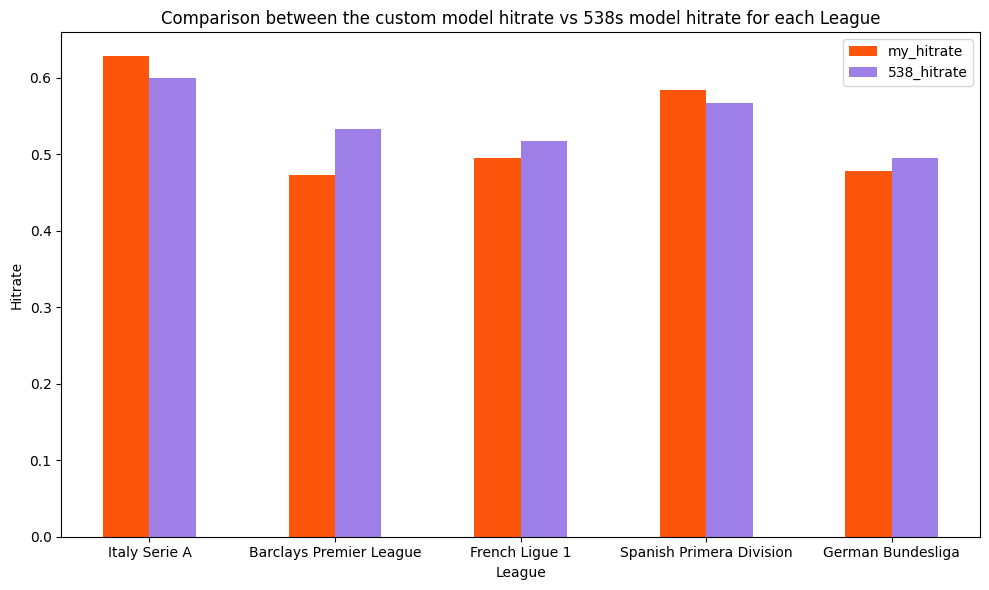

In [19]:
plt.figure(figsize=(10,6))
# Number of groups (number of leagues)
num_leagues = len(topleagues_results)

# Index for the x-axis
index = np.arange(num_leagues)

# Width of each bar
bar_width = 0.25

# Plotting the bars
for i, league in enumerate(topleagues_results['League']):
    plt.bar(index[i], topleagues_results.loc[i, 'my_hitrate'], bar_width, label='my_hitrate', color=color_1)
    plt.bar(index[i] + bar_width, topleagues_results.loc[i, '538_hitrate'], bar_width, label='538_hitrate', color=color_2)

# Adding labels, title, and legend

plt.xlabel('League')
plt.ylabel('Hitrate')
plt.title('Comparison between the custom model hitrate vs 538s model hitrate for each League')
plt.xticks(index + bar_width /2 , topleagues_results['League'])

# Specifying legend labels and position
plt.legend(['my_hitrate', '538_hitrate'], loc='upper right')

# Save the plot before displaying it
plt.savefig('images/comparison.png')

# Display the plot
plt.tight_layout()
plt.show()
